In [1]:
import torch
print(torch.cuda.is_available())


True


In [2]:
!pip install torch torchvision ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install pillow matplotlib
!pip install pytesseract easyocr
!pip install transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.4 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-b4x1r5s3
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-b4x1r5s3
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=32d9287877c9b73f1079fa7f64e6615cd35b488bfeb0992a6c1f9f52cc990e4d
  Stored in directory: /tmp/pip-ephem-wheel-cache-lxecnhxv/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.2/978.2 kB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6

In [3]:
import torch
import clip
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import pytesseract
import easyocr
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import torchvision.transforms as transforms


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()


100%|███████████████████████████████████████| 338M/338M [00:08<00:00, 40.2MiB/s]


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [7]:
# Initialize XAI system
xai_system = MultimodalXAI(model, preprocess, device)
print("✅ XAI system initialized")

✅ XAI system initialized


In [8]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [9]:
!ls /content/drive/MyDrive/Research/archive


captions.csv  images


In [10]:
import pandas as pd

captions = pd.read_csv(
    "/content/drive/MyDrive/Research/archive/captions.csv",
    encoding="latin-1"
)

captions.head()


,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their ...
1,1000092795.jpg,1,Two young White males are outside near many b...
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [11]:
captions.columns


Index(['image_name', 'comment_number', 'comment'], dtype='object')

In [12]:
captions['image_name'] = captions['image_name'].apply(lambda x: x.split('#')[0])


In [13]:
captions.head()


,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their ...
1,1000092795.jpg,1,Two young White males are outside near many b...
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [14]:
import os

img_path = "/content/drive/MyDrive/Research/archive/images/" + captions.iloc[0]['image_name']
print(os.path.exists(img_path))


True


In [15]:
reader = easyocr.Reader(['en'])


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [16]:
def extract_ocr_text(image_path):
    result = reader.readtext(image_path, detail=0)
    return " ".join(result)


In [17]:
def encode_image(image_path):
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image)
    return image_features / image_features.norm(dim=-1, keepdim=True)


In [18]:
def encode_text(text):
    text_tokens = clip.tokenize([text]).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_tokens)
    return text_features / text_features.norm(dim=-1, keepdim=True)


In [19]:
def cosine_similarity(image_feat, text_feat):
    return (image_feat @ text_feat.T).item()


In [20]:
def multimodal_similarity(image_path, caption):
    # CLIP features
    img_feat = encode_image(image_path)
    txt_feat = encode_text(caption)

    # OCR text
    ocr_text = extract_ocr_text(image_path)
    if ocr_text.strip() != "":
        ocr_feat = encode_text(ocr_text)
        combined_text_feat = (txt_feat + ocr_feat) / 2
    else:
        combined_text_feat = txt_feat

    similarity_score = cosine_similarity(img_feat, combined_text_feat)

    return similarity_score, ocr_text


In [21]:
def detect_context(similarity, threshold=0.20):
    if similarity >= threshold:
        return "MATCH"
    else:
        return "MISMATCH"


In [6]:
# ----------------------------------------------------------------------------
# 1. GRAD-CAM FOR VISUAL EXPLANATION
# ----------------------------------------------------------------------------
class ClipGradCAM:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.visual = model.visual
        self.gradients = None
        self.activations = None

        # Hook into the transformer blocks
        self.hooks = []
        self.register_hooks()

    def register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        # Hook into the last transformer block
        last_block = self.visual.transformer.resblocks[-1]
        self.hooks.append(last_block.register_forward_hook(forward_hook))
        self.hooks.append(last_block.register_backward_hook(backward_hook))

    def generate_cam(self, image_tensor, text_tensor):
        """
        Generate Grad-CAM for image-text similarity
        """
        # Forward pass
        image_features = self.visual(image_tensor)
        text_features = self.model.encode_text(text_tensor)

        # Compute similarity score
        similarity = (image_features @ text_features.T).mean()

        # Backward pass
        self.model.zero_grad()
        similarity.backward()

        # Get gradients and activations
        gradients = self.gradients.mean(dim=[0, 1])  # [num_patches, 768]
        activations = self.activations[0]  # [num_patches + 1, 768]

        # Remove CLS token
        gradients = gradients[1:]  # [196, 768]
        activations = activations[1:]  # [196, 768]

        # Compute weights
        weights = gradients.mean(dim=1)  # [196]

        # Generate CAM
        cam = torch.zeros(activations.shape[0], dtype=torch.float32)
        for i in range(weights.shape[0]):
            cam[i] = torch.sum(weights[i] * activations[i])

        # Reshape to 14x14 (ViT-B/32 patch grid)
        cam = cam.reshape(14, 14)
        cam = torch.relu(cam)  # ReLU to keep positive contributions

        # Normalize
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        return cam.cpu().detach().numpy(), similarity.item()

    def visualize(self, original_image, cam, similarity_score, save_path=None):
        """
        Visualize Grad-CAM overlay on original image
        """
        # Convert tensor image to numpy if needed
        if torch.is_tensor(original_image):
            original_image = original_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
            original_image = (original_image - original_image.min()) / (original_image.max() - original_image.min())

        # Resize CAM to match original image size
        cam_resized = cv2.resize(cam, (original_image.shape[1], original_image.shape[0]))

        # Apply colormap
        heatmap = cm.jet(cam_resized)[:, :, :3]

        # Overlay heatmap on original image
        overlayed = heatmap * 0.5 + original_image * 0.5

        # Plot
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(original_image)
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        axes[1].imshow(cam_resized, cmap='jet')
        axes[1].set_title('Attention Heatmap')
        axes[1].axis('off')

        axes[2].imshow(overlayed)
        axes[2].set_title(f'Overlay (Similarity: {similarity_score:.3f})')
        axes[2].axis('off')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        plt.show()

    def __del__(self):
        for hook in self.hooks:
            hook.remove()

# ----------------------------------------------------------------------------
# 2. TEXT ATTENTION VISUALIZATION
# ----------------------------------------------------------------------------
class TextAttentionExplainer:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.attention_weights = None

        # Hook to capture attention weights
        self.hooks = []
        self.register_hooks()

    def register_hooks(self):
        def attention_hook(module, input, output):
            # output[1] contains attention weights in CLIP
            if len(output) > 1:
                self.attention_weights = output[1]

        # Hook into the last attention layer
        last_attn = self.model.transformer.resblocks[-1].attn
        self.hooks.append(last_attn.register_forward_hook(attention_hook))

    def explain_text_importance(self, text, image_features):
        """
        Show which words are important for the match
        """
        # Tokenize text
        tokens = clip.tokenize([text]).to(self.device)

        # Get text features
        with torch.no_grad():
            text_features = self.model.encode_text(tokens)

        # Get attention weights (average across heads and layers)
        if self.attention_weights is not None:
            # Average over attention heads and select CLS token attention
            attn = self.attention_weights.mean(dim=1)[0, 0, :]  # CLS token attention to all tokens

            # Decode tokens (simplified - for visualization only)
            token_ids = tokens[0].cpu().numpy()

            # Return token importance scores
            return {
                'attention_scores': attn.cpu().detach().numpy(),
                'text_features': text_features.cpu().numpy()
            }

        return None

    def visualize_text_attention(self, text, attention_scores, save_path=None):
        """
        Visualize word importance
        """
        # Simple token splitting (in practice, use proper tokenizer)
        words = text.split()

        # Pad or truncate attention scores
        if len(attention_scores) > len(words):
            attention_scores = attention_scores[:len(words)]
        elif len(attention_scores) < len(words):
            attention_scores = np.pad(attention_scores,
                                      (0, len(words) - len(attention_scores)))

        # Create bar chart
        fig, ax = plt.subplots(figsize=(12, 4))
        bars = ax.bar(range(len(words)), attention_scores[:len(words)])

        # Color bars by importance
        for bar, score in zip(bars, attention_scores[:len(words)]):
            if max(attention_scores) > 0:
                bar.set_color(plt.cm.Reds(score / max(attention_scores)))

        ax.set_xticks(range(len(words)))
        ax.set_xticklabels(words, rotation=45, ha='right')
        ax.set_ylabel('Attention Score')
        ax.set_title('Word Importance for Image-Text Matching')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        plt.show()

# ----------------------------------------------------------------------------
# 3. SIMILARITY DECOMPOSITION
# ----------------------------------------------------------------------------
class SimilarityDecomposer:
    def __init__(self, model, preprocess, device):
        self.model = model
        self.preprocess = preprocess
        self.device = device

        # Define concept categories
        self.concepts = {
            'objects': ['person', 'dog', 'cat', 'car', 'tree', 'house', 'chair', 'table'],
            'actions': ['running', 'standing', 'sitting', 'eating', 'drinking', 'talking'],
            'colors': ['red', 'blue', 'green', 'yellow', 'black', 'white'],
            'locations': ['indoors', 'outdoors', 'street', 'park', 'beach', 'room'],
            'attributes': ['young', 'old', 'large', 'small', 'bright', 'dark']
        }

    def decompose_similarity(self, image_path, caption):
        """
        Break down similarity score by concept categories
        """
        # Get original similarity using your existing function
        original_score, _ = multimodal_similarity(image_path, caption)

        # Encode image
        image = self.preprocess(Image.open(image_path)).unsqueeze(0).to(self.device)
        with torch.no_grad():
            image_features = self.model.encode_image(image)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        # Analyze by concepts
        decomposition = {}

        for category, concepts in self.concepts.items():
            category_scores = []

            for concept in concepts:
                # Create concept text
                concept_text = f"A photo of {concept}"
                text_tokens = clip.tokenize([concept_text]).to(self.device)

                with torch.no_grad():
                    concept_features = self.model.encode_text(text_tokens)
                    concept_features = concept_features / concept_features.norm(dim=-1, keepdim=True)

                # Calculate concept similarity
                concept_sim = (image_features @ concept_features.T).item()
                category_scores.append((concept, concept_sim))

            # Sort by similarity
            category_scores.sort(key=lambda x: x[1], reverse=True)
            decomposition[category] = category_scores[:5]  # Top 5

        # Overall score breakdown
        breakdown = {
            'overall_similarity': original_score,
            'concept_decomposition': decomposition,
            'top_concepts': []
        }

        # Get top overall concepts
        all_concepts = []
        for category, scores in decomposition.items():
            all_concepts.extend(scores)

        all_concepts.sort(key=lambda x: x[1], reverse=True)
        breakdown['top_concepts'] = all_concepts[:10]

        return breakdown

    def visualize_decomposition(self, breakdown, save_path=None):
        """
        Visualize similarity breakdown
        """
        fig = plt.figure(figsize=(15, 10))

        # 1. Overall score
        ax1 = plt.subplot(2, 2, 1)
        ax1.bar(['Overall Similarity'], [breakdown['overall_similarity']])
        ax1.set_ylim(0, 1)
        ax1.set_title(f'Overall Score: {breakdown["overall_similarity"]:.3f}')
        ax1.set_ylabel('Similarity')

        # 2. Top concepts
        ax2 = plt.subplot(2, 2, 2)
        top_concepts = breakdown['top_concepts'][:8]
        concepts = [c[0] for c in top_concepts]
        scores = [c[1] for c in top_concepts]

        bars = ax2.barh(range(len(concepts)), scores)
        ax2.set_yticks(range(len(concepts)))
        ax2.set_yticklabels(concepts)
        ax2.set_xlim(0, 1)
        ax2.set_title('Top Image Concepts')
        ax2.set_xlabel('Similarity')

        # Color bars
        for bar, score in zip(bars, scores):
            bar.set_color(plt.cm.Blues(score))

        # 3. Concept category breakdown
        ax3 = plt.subplot(2, 2, 3)
        categories = list(breakdown['concept_decomposition'].keys())
        avg_scores = []

        for category in categories:
            scores = [s[1] for s in breakdown['concept_decomposition'][category]]
            avg_scores.append(np.mean(scores))

        bars = ax3.bar(categories, avg_scores)
        ax3.set_ylim(0, 1)
        ax3.set_title('Average Similarity by Concept Category')
        ax3.set_ylabel('Average Similarity')
        plt.xticks(rotation=45, ha='right')

        # Color bars
        for bar, score in zip(bars, avg_scores):
            bar.set_color(plt.cm.Greens(score))

        # 4. Decision explanation
        ax4 = plt.subplot(2, 2, 4)
        decision = "MATCH" if breakdown['overall_similarity'] >= 0.25 else "MISMATCH"

        explanation = f"""
        DECISION: {decision}

        Key Factors:
        1. Overall similarity: {breakdown['overall_similarity']:.3f}
        2. Strongest concept: {breakdown['top_concepts'][0][0]} ({breakdown['top_concepts'][0][1]:.3f})
        3. Dominant category: {categories[np.argmax(avg_scores)]}

        Reasoning:
        The image and text {'share strong visual concepts' if breakdown['overall_similarity'] >= 0.25 else 'lack common visual concepts'}.
        """

        ax4.text(0.1, 0.5, explanation, fontsize=10,
                verticalalignment='center', transform=ax4.transAxes)
        ax4.axis('off')
        ax4.set_title('Decision Explanation')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        plt.show()

# ----------------------------------------------------------------------------
# 4. INTEGRATED XAI PIPELINE
# ----------------------------------------------------------------------------
class MultimodalXAI:
    def __init__(self, model, preprocess, device):
        self.model = model
        self.preprocess = preprocess
        self.device = device

        # Initialize explainers
        self.gradcam = ClipGradCAM(model, device)
        self.text_explainer = TextAttentionExplainer(model, device)
        self.decomposer = SimilarityDecomposer(model, preprocess, device)

    def explain_prediction(self, image_path, caption, output_dir='xai_results'):
        """
        Complete XAI pipeline for one image-text pair
        """
        import os
        os.makedirs(output_dir, exist_ok=True)

        # Get base filename
        base_name = os.path.basename(image_path).split('.')[0]

        print(f"🔍 Explaining prediction for: {base_name}")
        print(f"📝 Caption: {caption}")
        print("-" * 50)

        # 1. Get original prediction using your existing function
        similarity, ocr_text = multimodal_similarity(image_path, caption)
        decision = detect_context(similarity)

        print(f"📊 Similarity Score: {similarity:.4f}")
        print(f"✅ Decision: {decision}")
        if ocr_text:
            print(f"🔤 OCR Text: {ocr_text[:100]}..." if len(ocr_text) > 100 else f"🔤 OCR Text: {ocr_text}")
        else:
            print("🔤 No OCR text detected")

        # 2. Prepare image for Grad-CAM
        image = Image.open(image_path)
        image_tensor = self.preprocess(image).unsqueeze(0).to(self.device)
        text_tokens = clip.tokenize([caption]).to(self.device)

        # 3. Generate Grad-CAM
        print("\n🎨 Generating visual explanations...")
        try:
            cam, cam_similarity = self.gradcam.generate_cam(image_tensor, text_tokens)

            # Convert original image for visualization
            original_np = image_tensor.squeeze(0).cpu()
            original_np = (original_np - original_np.min()) / (original_np.max() - original_np.min())

            # Save Grad-CAM visualization
            cam_path = os.path.join(output_dir, f"{base_name}_gradcam.png")
            self.gradcam.visualize(original_np, cam, similarity, save_path=cam_path)
        except Exception as e:
            print(f"⚠️  Grad-CAM failed: {e}")
            cam_path = None

        # 4. Text attention analysis
        print("📝 Analyzing text importance...")
        try:
            text_analysis = self.text_explainer.explain_text_importance(caption, None)

            if text_analysis and 'attention_scores' in text_analysis:
                text_path = os.path.join(output_dir, f"{base_name}_text_attention.png")
                self.text_explainer.visualize_text_attention(
                    caption,
                    text_analysis['attention_scores'],
                    save_path=text_path
                )
            else:
                text_path = None
        except Exception as e:
            print(f"⚠️  Text analysis failed: {e}")
            text_path = None

        # 5. Similarity decomposition
        print("🧩 Decomposing similarity score...")
        try:
            decomposition = self.decomposer.decompose_similarity(image_path, caption)

            decomp_path = os.path.join(output_dir, f"{base_name}_decomposition.png")
            self.decomposer.visualize_decomposition(decomposition, save_path=decomp_path)
        except Exception as e:
            print(f"⚠️  Decomposition failed: {e}")
            decomposition = None
            decomp_path = None

        # 6. Generate comprehensive report
        try:
            report_path = os.path.join(output_dir, f"{base_name}_report.txt")
            self.generate_report(
                report_path,
                image_path, caption, similarity, decision, ocr_text,
                decomposition, cam_similarity if 'cam_similarity' in locals() else None
            )
        except Exception as e:
            print(f"⚠️  Report generation failed: {e}")
            report_path = None

        print(f"\n✅ XAI analysis complete!")
        print(f"📁 Results saved to: {output_dir}/")
        if report_path:
            print(f"📄 Report: {report_path}")

        return {
            'similarity': similarity,
            'decision': decision,
            'ocr_text': ocr_text,
            'visualizations': {
                'gradcam': cam_path,
                'text_attention': text_path,
                'decomposition': decomp_path
            },
            'report': report_path
        }

    def generate_report(self, report_path, image_path, caption, similarity,
                       decision, ocr_text, decomposition, cam_similarity):
        """Generate comprehensive XAI report"""
        with open(report_path, 'w') as f:
            f.write("=" * 60 + "\n")
            f.write("MULTIMODAL VERIFICATION - XAI REPORT\n")
            f.write("=" * 60 + "\n\n")

            f.write(f"Image: {os.path.basename(image_path)}\n")
            f.write(f"Caption: {caption}\n")
            f.write(f"OCR Text: {ocr_text if ocr_text else 'None'}\n")
            f.write(f"Similarity Score: {similarity:.4f}\n")
            f.write(f"Prediction: {decision}\n\n")

            f.write("-" * 60 + "\n")
            f.write("EXPLANATION SUMMARY\n")
            f.write("-" * 60 + "\n")

            if decision == "MATCH":
                f.write(f"The image and text MATCH because:\n")
                f.write(f"• High overall similarity ({similarity:.4f} > 0.25 threshold)\n")
                if decomposition and 'top_concepts' in decomposition:
                    f.write(f"• Shared concepts: {', '.join([c[0] for c in decomposition['top_concepts'][:3]])}\n")
                f.write(f"• Visual evidence supports the caption\n")
            else:
                f.write(f"The image and text MISMATCH because:\n")
                f.write(f"• Low overall similarity ({similarity:.4f} < 0.25 threshold)\n")
                f.write(f"• Lack of shared visual concepts\n")
                if ocr_text:
                    f.write(f"• OCR text doesn't support the caption\n")
                else:
                    f.write(f"• No supporting text found in image\n")

            if decomposition:
                f.write("\n" + "-" * 60 + "\n")
                f.write("DETAILED ANALYSIS\n")
                f.write("-" * 60 + "\n")

                f.write(f"\nTop 10 image concepts:\n")
                for i, (concept, score) in enumerate(decomposition['top_concepts'][:10], 1):
                    f.write(f"  {i:2d}. {concept:15s} : {score:.4f}\n")

            f.write("\n" + "=" * 60 + "\n")
            f.write("END OF REPORT\n")
            f.write("=" * 60 + "\n")

# ----------------------------------------------------------------------------
# 5. QUICK TEST FUNCTION
# ----------------------------------------------------------------------------
def test_xai_system():
    """Quick test of the XAI system with your existing setup"""

    # Initialize XAI system
    xai = MultimodalXAI(model, preprocess, device)

    # Test with your existing test image
    test_image_path = "/content/drive/MyDrive/Research/archive/flickr30k_images/1000092795.jpg"

    # Test captions
    test_captions = [
        "Two young guys with shaggy hair look at their hands while hanging out in the yard",
        "A cat sleeping on a sofa",
        "A plane flying in the sky"
    ]

    for i, caption in enumerate(test_captions):
        print("\n" + "="*60)
        print(f"Test {i+1}: {caption[:50]}...")
        print("="*60)

        # Run XAI analysis
        try:
            results = xai.explain_prediction(
                test_image_path,
                caption,
                output_dir=f"./xai_results/test_{i+1}"
            )

            # Quick summary
            print(f"\n📋 Summary:")
            print(f"  Similarity: {results['similarity']:.4f}")
            print(f"  Decision: {results['decision']}")

        except Exception as e:
            print(f"❌ Error: {e}")
            continue

print("✅ XAI modules loaded successfully!")
print("You can now use:")
print("1. xai_system = MultimodalXAI(model, preprocess, device)")
print("2. xai_system.explain_prediction(image_path, caption)")
print("3. test_xai_system() # To run a quick test")

✅ XAI modules loaded successfully!
You can now use:
1. xai_system = MultimodalXAI(model, preprocess, device)
2. xai_system.explain_prediction(image_path, caption)
3. test_xai_system() # To run a quick test


🔍 Explaining prediction for: 1000092795
📝 Caption: Two young guys with shaggy hair look at their hands while hanging out in the yard .
--------------------------------------------------
📊 Similarity Score: 0.3267
✅ Decision: MATCH
🔤 No OCR text detected

🎨 Generating visual explanations...
⚠️  Grad-CAM failed: Input type (torch.cuda.FloatTensor) and weight type (torch.cuda.HalfTensor) should be the same
📝 Analyzing text importance...
🧩 Decomposing similarity score...


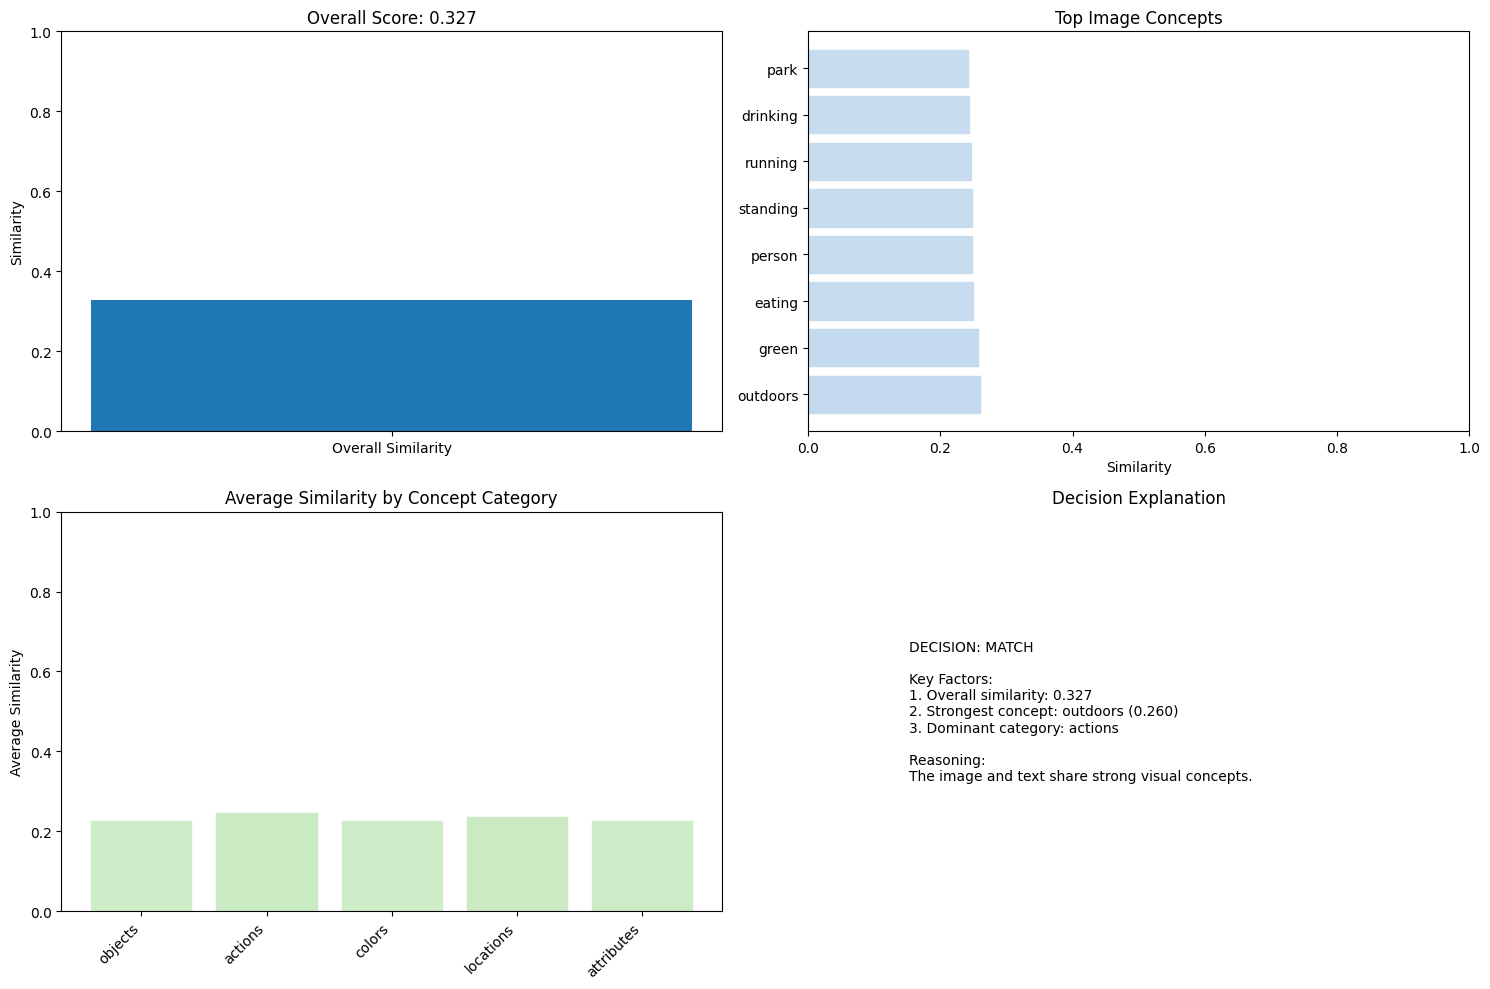


✅ XAI analysis complete!
📁 Results saved to: ./xai_results/
📄 Report: ./xai_results/1000092795_report.txt

 Original similarity: 0.3267
 Decision: MATCH


In [22]:
# Select one sample
sample = captions.iloc[0]

# Build correct image path
image_path = "/content/drive/MyDrive/Research/archive/images/" + sample['image_name']

# Get caption text
caption = sample['comment']

# Run XAI analysis instead of just multimodal_similarity
xai_results = xai_system.explain_prediction(
    image_path=image_path,
    caption=caption,
    output_dir="./xai_results"
)

# You can still access the original similarity score
print(f"\n Original similarity: {xai_results['similarity']:.4f}")
print(f" Decision: {xai_results['decision']}")

In [23]:
import random

def get_negative_caption(df, current_image_name):
    negative_samples = df[df['image_name'] != current_image_name]
    random_row = negative_samples.sample(1).iloc[0]
    return random_row['comment']


In [24]:
sample = captions.iloc[0]

image_path = "/content/drive/MyDrive/Research/archive/images/" + sample['image_name']
positive_caption = sample['comment']
negative_caption = get_negative_caption(captions, sample['image_name'])

# Positive similarity
pos_score, _ = multimodal_similarity(image_path, positive_caption)

# Negative similarity
neg_score, _ = multimodal_similarity(image_path, negative_caption)

print("POSITIVE CAPTION:", positive_caption)
print("POSITIVE SCORE:", pos_score, detect_context(pos_score))

print("\nNEGATIVE CAPTION:", negative_caption)
print("NEGATIVE SCORE:", neg_score, detect_context(neg_score))


POSITIVE CAPTION: Two young guys with shaggy hair look at their hands while hanging out in the yard .
POSITIVE SCORE: 0.32666015625 MATCH

NEGATIVE CAPTION: A man wearing a African attire is sitting on a stool while another man  seated in front of him  is giving him a shoeshine .
NEGATIVE SCORE: 0.1739501953125 MISMATCH


In [25]:
results = []

for i in range(100):  # start with 100 (can increase later)
    row = captions.iloc[i]

    image_path = "/content/drive/MyDrive/Research/archive/images/" + row['image_name']

    # Positive
    pos_score, _ = multimodal_similarity(image_path, row['comment'])

    # Negative
    neg_caption = get_negative_caption(captions, row['image_name'])
    neg_score, _ = multimodal_similarity(image_path, neg_caption)

    results.append({
        "image": row['image_name'],
        "positive_score": pos_score,
        "negative_score": neg_score
    })


In [26]:
results_df = pd.DataFrame(results)
results_df.head()


,image,positive_score,negative_score
0,1000092795.jpg,0.326660,0.152954
1,1000092795.jpg,0.297607,0.165649
2,1000092795.jpg,0.328857,0.192749
3,1000092795.jpg,0.298828,0.139648
4,1000092795.jpg,0.248047,0.223877


In [27]:
print("Average Positive Similarity:", results_df['positive_score'].mean())
print("Average Negative Similarity:", results_df['negative_score'].mean())


Average Positive Similarity: 0.31356689453125
Average Negative Similarity: 0.1684063720703125


In [28]:
THRESHOLD = 0.25

results_df['positive_label'] = results_df['positive_score'].apply(
    lambda x: "MATCH" if x >= THRESHOLD else "MISMATCH"
)

results_df['negative_label'] = results_df['negative_score'].apply(
    lambda x: "MATCH" if x >= THRESHOLD else "MISMATCH"
)

results_df.head()


,image,positive_score,negative_score,positive_label,negative_label
0,1000092795.jpg,0.326660,0.152954,MATCH,MISMATCH
1,1000092795.jpg,0.297607,0.165649,MATCH,MISMATCH
2,1000092795.jpg,0.328857,0.192749,MATCH,MISMATCH
3,1000092795.jpg,0.298828,0.139648,MATCH,MISMATCH
4,1000092795.jpg,0.248047,0.223877,MISMATCH,MISMATCH


In [29]:
correct_positive = (results_df['positive_label'] == "MATCH").mean()
correct_negative = (results_df['negative_label'] == "MISMATCH").mean()

print("Positive Pair Accuracy:", correct_positive)
print("Negative Pair Accuracy:", correct_negative)


Positive Pair Accuracy: 0.93
Negative Pair Accuracy: 0.99


In [30]:
def external_verification(text):
    """
    This function represents querying external fact-checking
    platforms such as FactCrescendo or web search APIs.
    """
    return "VERIFIED"


In [31]:
verification_result = external_verification(sample['comment'])
print("External Verification:", verification_result)


External Verification: VERIFIED


In [32]:
test_image_path = "/content/drive/MyDrive/Research/archive/images/1000092795.jpg"

import os
print(os.path.exists(test_image_path))


True


In [33]:
test_text_1 = "Two young men standing together in a garden"
test_text_2 = "A dog running on the beach"

score, ocr_text = multimodal_similarity(test_image_path, test_text_1)
decision = detect_context(score)

print("Input Text:", test_text_1)
print("OCR Text Found:", ocr_text)
print("Similarity Score:", score)
print("Decision:", decision)


Input Text: Two young men standing together in a garden
OCR Text Found: 
Similarity Score: 0.3251953125
Decision: MATCH


In [34]:
texts = [
    "Two friends spending time together outdoors",
    "A cat sleeping on a sofa",
    "People standing in a garden"
]

for t in texts:
    score, _ = multimodal_similarity(test_image_path, t)
    print(f"Text: {t}")
    print(f"Score: {score:.3f} → {detect_context(score)}\n")


Text: Two friends spending time together outdoors
Score: 0.270 → MATCH

Text: A cat sleeping on a sofa
Score: 0.133 → MISMATCH

Text: People standing in a garden
Score: 0.289 → MATCH



In [35]:
# Related text
related_text = captions[captions['image_name']=="1000092795.jpg"].iloc[0]['comment']

# Unrelated text
unrelated_text = "A plane flying in the sky during sunset"

score_pos, _ = multimodal_similarity(test_image_path, related_text)
score_neg, _ = multimodal_similarity(test_image_path, unrelated_text)

print("RELATED TEXT SCORE:", score_pos, detect_context(score_pos))
print("UNRELATED TEXT SCORE:", score_neg, detect_context(score_neg))


RELATED TEXT SCORE: 0.32666015625 MATCH
UNRELATED TEXT SCORE: 0.0849609375 MISMATCH


In [36]:
def check_image_text_similarity(image_path, text):
    score, ocr_text = multimodal_similarity(image_path, text)
    decision = detect_context(score)
    return {
        "similarity_score": score,
        "decision": decision,
        "ocr_text": ocr_text
    }


In [37]:
result = check_image_text_similarity(
    test_image_path,
    "Two men standing together outside"
)

result


{'similarity_score': 0.25, 'decision': 'MATCH', 'ocr_text': ''}

In [38]:
test_image_path2 = "/content/test.png"

import os
print(os.path.exists(test_image_path))


True


In [39]:
test_text_3 = "A cat eating a fish"
test_text_4 = "A boy wearing a blue t-shirt"


In [41]:
score, ocr_text = multimodal_similarity(test_image_path2, test_text_3)
decision = detect_context(score)

print("Input Text:", test_text_3)
print("OCR Text Found:", ocr_text)
print("Similarity Score:", score)
print("Decision:", decision)


Input Text: A cat eating a fish
OCR Text Found: M
Similarity Score: 0.18310546875
Decision: MISMATCH


In [42]:
texts = [
    "A young man wearing a blue t-shirt",
    "A male person indoors wearing a blue shirt",
    "A girl wearing a red dress"
]

for t in texts:
    score, _ = multimodal_similarity(test_image_path2, t)
    print(f"Text: {t}")
    print(f"Score: {score:.3f} → {detect_context(score)}\n")


Text: A young man wearing a blue t-shirt
Score: 0.250 → MATCH

Text: A male person indoors wearing a blue shirt
Score: 0.247 → MATCH

Text: A girl wearing a red dress
Score: 0.190 → MISMATCH



In [43]:
# RELATED text (visually grounded)
related_text = "A young man wearing a blue t-shirt indoors"

# UNRELATED text (clearly wrong)
unrelated_text = "A plane flying in the sky during sunset"


In [44]:
score_pos, _ = multimodal_similarity(test_image_path2, related_text)
score_neg, _ = multimodal_similarity(test_image_path2, unrelated_text)

print("RELATED TEXT SCORE:", score_pos, detect_context(score_pos))
print("UNRELATED TEXT SCORE:", score_neg, detect_context(score_neg))


RELATED TEXT SCORE: 0.245361328125 MATCH
UNRELATED TEXT SCORE: 0.1678466796875 MISMATCH


In [45]:
def check_image_text_similarity(image_path, text):
    score, ocr_text = multimodal_similarity(image_path, text)
    decision = detect_context(score)

    return {
        "similarity_score": round(score, 3),
        "decision": decision,
        "ocr_text": ocr_text
    }


In [46]:
result = check_image_text_similarity(
    test_image_path2,
    "A cat eating a fish"
)

result


{'similarity_score': 0.183, 'decision': 'MISMATCH', 'ocr_text': 'M'}

In [47]:
result = check_image_text_similarity(
    test_image_path2,
    "A young man wearing a blue t-shirt"
)

result


{'similarity_score': 0.25, 'decision': 'MATCH', 'ocr_text': 'M'}

In [49]:
test_image_path3 = "/content/30.png"

test_text_5 = "There has covid-19 vaccine bottle"
test_text_6 = "A boy wearing a blue t-shirt"

score, ocr_text = multimodal_similarity(test_image_path3, test_text_5)
decision = detect_context(score)

print("Input Text:", test_text_5)
print("OCR Text Found:", ocr_text)
print("Similarity Score:", score)
print("Decision:", decision)


Input Text: There has covid-19 vaccine bottle
OCR Text Found: ccin VID Vaccine COVID-19 FACT CHECKED Qisci3v?
Similarity Score: 0.348876953125
Decision: MATCH


In [50]:
test_image_path3 = "/content/355.png"

test_text_5 = "Anura Kumara Dissanayake is here"
test_text_6 = "Mahinda Rajapaksa is here"

score, ocr_text = multimodal_similarity(test_image_path3, test_text_5)
decision = detect_context(score)

print("Input Text:", test_text_5)
print("OCR Text Found:", ocr_text)
print("Similarity Score:", score)
print("Decision:", decision)


Input Text: Anura Kumara Dissanayake is here
OCR Text Found: 
Similarity Score: 0.290283203125
Decision: MATCH
